# Optimal UTXO size for difficulty and static reward

Quickly find the optimal Peercoin UTXO size for a given difficulty and static reward. Parameters can be adjusted for the displayed chart.

This uses daily probabilities as an approximation for per-second probabilities. It also assumes minting occurs continuously.

Determines the probability distribution for mints across multiple days and then finds a geometric average reward weighted by these probabilities.

Produced by MattLM with credit to Nagalim for ideas and alternative solutions.

Tips are welcome: PTuwboaoow7XF7Vrr68oremimo9wgrvxQ6

In [2553]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6.0, 5.0]

## Parameters

In [2554]:
MAX_DAYS = 365*4
MIN_PROB_DAYS = 30
RAMP_UP = 60
RELATIVE_REWARD = 0.03
BLOCK_INTERVAL_SECS = 60*10

In [2555]:
# Supply in coins. Whilst the total supply can be used, some coins may be considerated irredeemable.
SUPPLY = 28327842
DIFF = 21.2025
STATIC_REWARD = 1.35
EXAMPLE_SIZE = 100

# Recommended to keep False.
# This compounds the return of a single-output.
# This under-estimates returns for a wallet with many small utxos as
# the slow-compounding effects are removed when there are many outputs.
GEOMETRIC=False

In [2556]:
# Security Parameter Definitions
# Hold Fixed:  PoS Difficulty = 0 ; Security Parameter = 1 ; 
STATISTICSFLAG = 1
# Define maxDayWeight here, because it is intrinsic to the statistics
maxDayWeight = RAMP_UP if RAMP_UP > 0 else 0.5
if STATISTICSFLAG==0:
    # Formal Definition of Security Parameter
    SECURITY = DIFF * 2**32 / (SUPPLY * maxDayWeight * BLOCK_INTERVAL_SECS)
    print("Security Parameter = %2.2f%%"%(100*SECURITY))
elif STATISTICSFLAG==1:
    # Override the Difficulty using a hardcoded Security Parameter
    
    SECURITY = 0.089296

    DIFF = SECURITY * SUPPLY * maxDayWeight * BLOCK_INTERVAL_SECS / (2**32)
    print("Implied Difficulty = %2.3f"%(DIFF))
elif STATISTICSFLAG==2:
    # Reserved for 'participation fraction' definition
    PARTICIPATION = SECURITY

Implied Difficulty = 21.203


## Helpful constants

In [2557]:
SECDAY=60*60*24
DAYYEAR=(365*33+8)/33
# Offset days by 0.5 to assume mint occurs somewhere in middle of day
DAYS = [MIN_PROB_DAYS+x+0.5 for x in range(MAX_DAYS)]
NO_MINT_DAY = MAX_DAYS+MIN_PROB_DAYS
DAYS_WITH_NO_MINT = DAYS + [NO_MINT_DAY]

## Calculate daily probability distribution

Includes the rampup

In [2558]:
# Max weight is the ramp up or assume a constant half day if no ramp up
# Offset by 0.5 to assume middle of day
dayWeights = np.clip(np.arange(MAX_DAYS) + 0.5, 0, maxDayWeight)
# The definition of the 'security parameter' ensures that the dayWeights are treated consistently
probSecs = dayWeights / 2**32

In [2559]:
def generateDailyProbs(outValue, diff):
    
    adj = outValue / diff

    # Independent probabilities
    failDayProbs = (1 - probSecs*adj)**SECDAY
    mintDayProbs = 1 - failDayProbs

    # Actual probability of mint on day assuming no mints before
    cumFail = failDayProbs.cumprod()
    # Prob of fail up-to now
    cumPrevFail = np.insert(cumFail, 0, 1)[:MAX_DAYS]
    # Prob of fail up-to now and success now gives chance of mint on this day
    # Add probabilty of final day to represent no successful mints
    return np.append(cumPrevFail*mintDayProbs, cumFail[-1])
        

In [2560]:
dayProbs = generateDailyProbs(EXAMPLE_SIZE, DIFF)

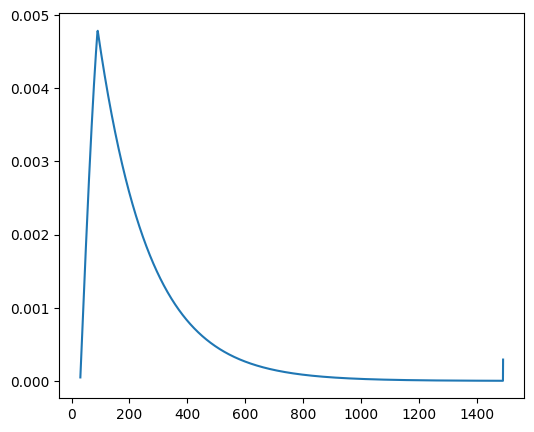

In [2561]:
plt.plot(DAYS_WITH_NO_MINT, dayProbs)
plt.show()

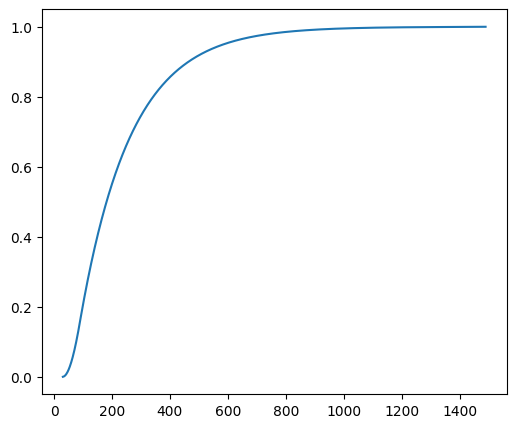

In [2562]:
plt.plot(DAYS_WITH_NO_MINT, dayProbs.cumsum())
plt.show()

In [2563]:
# Should add up to 1
dayProbs.sum()

1.0000000000000002

## Calculate Geometric average of rewards weighted by probabilities

In [2564]:
def dailyRewards(outValue, staticReward):
    mintRewards = np.fromiter((outValue*RELATIVE_REWARD*min(365, x)/DAYYEAR + staticReward for x in DAYS), dtype=float)
    includingFailed = np.append(mintRewards, 0)
    return includingFailed

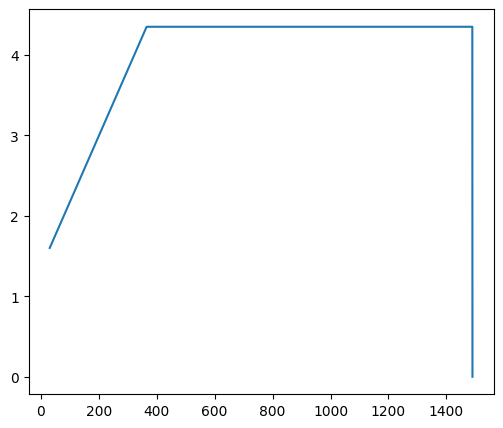

In [2565]:
rewards = dailyRewards(EXAMPLE_SIZE, STATIC_REWARD)
plt.plot(DAYS_WITH_NO_MINT, rewards)
plt.show()

In [2566]:
def averageReward(outValue, diff, staticReward, geometric=GEOMETRIC):
    probs = generateDailyProbs(outValue, diff)
    rewards = dailyRewards(outValue, staticReward)
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()

    if geometric:
        returns = 1+rewards/outValue
        weightedReturn = (returns**probs).prod()
        return (weightedReturn**(DAYYEAR/weightedTime) - 1) * 100

    # Arithmetic
    returns = rewards/outValue
    weightedReturn = (returns*probs).sum()
    return (weightedReturn*(DAYYEAR/weightedTime)) * 100

In [2567]:
averageReward(EXAMPLE_SIZE, DIFF, STATIC_REWARD)

4.703346195212842

## Plot UTXO sizes

In [2568]:
sizes = [10**(x/125) for x in range(501)]

In [2569]:
rewardForSizes = np.fromiter((averageReward(x, DIFF, STATIC_REWARD) for x in sizes), dtype=float)

In [2570]:
def addFigText(optimal):
    plt.figtext(0.5, -0.03, f"Additional parameters: percentage reward={RELATIVE_REWARD*100}%, min days={MIN_PROB_DAYS}, ramp days={RAMP_UP}, max days={MAX_DAYS}, geometric={GEOMETRIC}", ha="center", fontsize=10)
    plt.figtext(0.5, -0.08, f"Optimal UTXO Size: {optimal:.6f} PPC", ha="center", fontsize=10)

In [2571]:
def plotResults(results, yLabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sizes, results)
    ax.set_xlabel("UTXO Size")
    ax.set_ylabel(yLabel)
    ax.set_title(title)
    addFigText(sizes[results.argmax()])
    plt.xscale("log")
    plt.grid(which="both")
    plt.show()

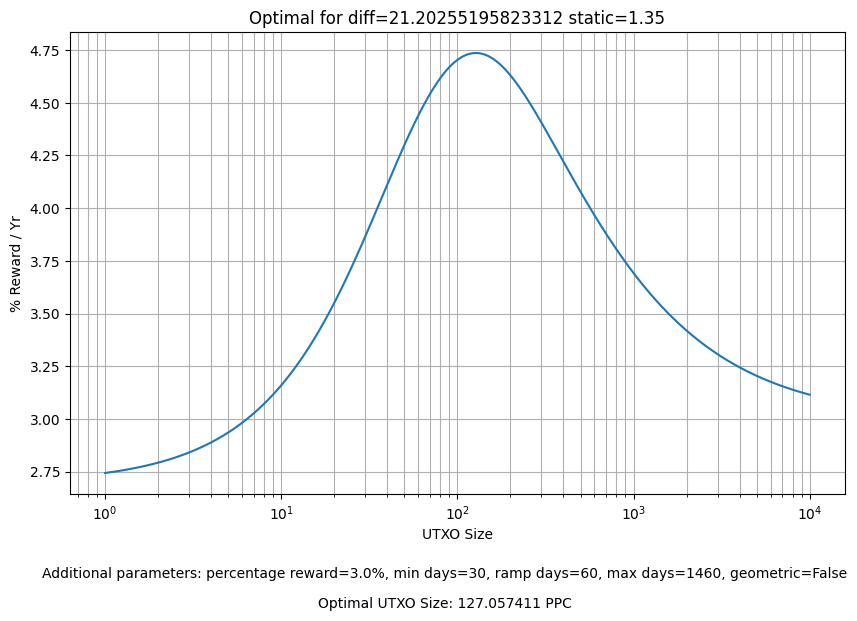

In [2572]:
plotResults(rewardForSizes, "% Reward / Yr", f"Optimal for diff={DIFF} static={STATIC_REWARD}")

## Number of Mints

In [2573]:
def averageMints(outValue, diff):
    probs = generateDailyProbs(outValue, diff)
    probFail = probs[-1]
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()
    return (1-probFail)/weightedTime/outValue*365

In [2574]:
mintsForSizes = np.fromiter((averageMints(x, DIFF) for x in sizes), dtype=float)

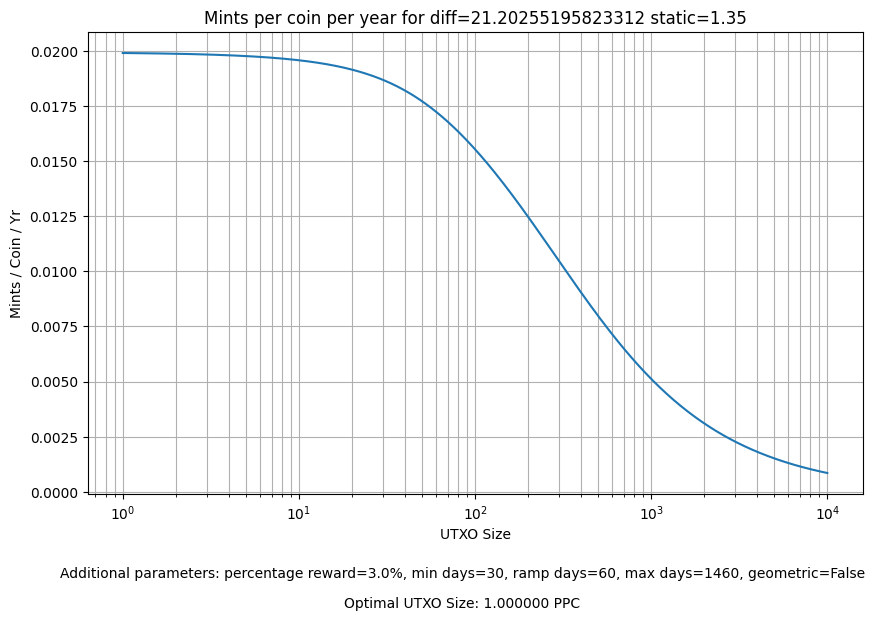

In [2575]:
plotResults(mintsForSizes, "Mints / Coin / Yr", f"Mints per coin per year for diff={DIFF} static={STATIC_REWARD}")

[8.15766400e-02 4.89773689e+01 3.16482107e-03 5.87980498e-01
 6.01559159e+00 6.49927033e-01 4.52563105e+01 4.00000000e-05
 4.45000000e-01 1.00000000e+01 1.00000000e+00 1.00000000e+00]


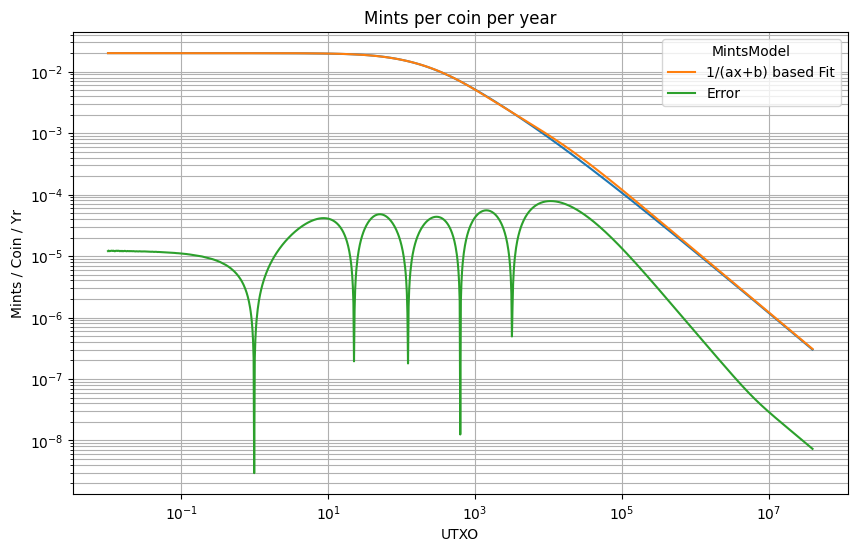

In [2580]:
# Extended range
extendedsizes = np.array([10**(x/125)/100 for x in range(1201)])

# This is the model we're using.  It's got a 1/(ax+b) part that is the main portion, then a gaussian-log, and then a 1/x^2 term too
# There could be better fits, but I would guess they must build off of 1/(ax+b) or an equivalent
def mintsModel(x,a,b,c,d,e,f,g,h,i,j,k,l):
    equation = (0.08157664*x+b)**(-1)-c*np.exp(-10**(-d)*(np.log(x)-e)**2)-(f*x+g)**(-2)
    return equation

# This is an empirically derived guess
FitGuess = np.array([0.08157664,50.10622554,3.01684816e-03,5.64338377e-01,6.09004148e+00,6.30317495e-01,4.31076089e+01,4e-05,0.445,10,1,1])

# Use curve_fit to build the fit parameters
fig, ax = plt.subplots(figsize=(10, 6))
mintsForSizes = np.fromiter((averageMints(x, DIFF) for x in extendedsizes), dtype=float)
FitParams, FitCurve = curve_fit(mintsModel,extendedsizes,(mintsForSizes),FitGuess,maxfev = 50000)
print(FitParams)

# plot everything
ax.plot(extendedsizes,mintsForSizes)
ax.plot(extendedsizes,mintsModel(extendedsizes, *FitParams),label="1/(ax+b) based Fit")
ax.plot(extendedsizes,np.abs(mintsModel(extendedsizes, *FitParams)-mintsForSizes),label="Error")

ax.set_xlabel("UTXO")
ax.set_ylabel("Mints / Coin / Yr")
ax.set_title("Mints per coin per year")
ax.legend(title="MintsModel")
plt.grid(which="both")
#plt.xlim(10**4,4*10**7)
#plt.ylim(0.0000005,0.005)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [2577]:
def generatedReward(outValue, diff, staticReward, geometric=GEOMETRIC):
    # If you use the equation, you'll see how sensitive it is at the long end of the spectrum
    #mints = mintsModel(outValue, *FitParams)
    mints = averageMints(outValue,diff)

    # Calculate a bunch of helper stuff that would be better done without using a full 'generateDailyProbs' function
    probs = generateDailyProbs(outValue, diff)
    weightedTime = (DAYS_WITH_NO_MINT*probs).sum()
    probFail = probs[-1]
    YearProb = probs.cumsum()[365-MIN_PROB_DAYS-1]
    ProbSucceed = weightedTime*outValue*mints/DAYYEAR
    YearRewardScale = 365/(weightedTime)*Maturation/DAYYEAR*1

    # Main reward calculation
    Rewards = RELATIVE_REWARD*YearProb+RELATIVE_REWARD*(ProbSucceed-YearProb)*YearRewardScale+staticReward*mints
    return (Rewards*100)

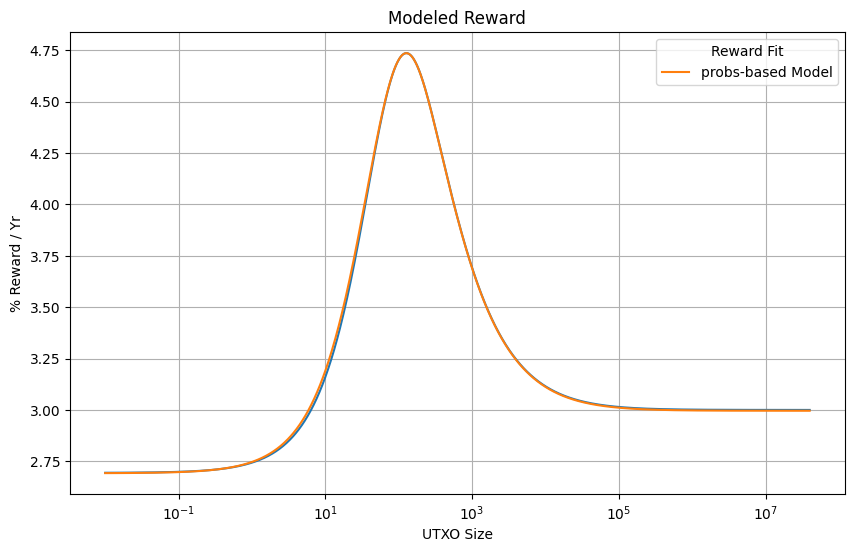

[8.15766400e-02 4.89773689e+01 3.16482107e-03 5.87980498e-01
 6.01559159e+00 6.49927033e-01 4.52563105e+01 4.00000000e-05
 4.45000000e-01 1.00000000e+01 1.00000000e+00 1.00000000e+00]


In [2581]:
# Plotting stuff
rewardForSizes = np.fromiter((averageReward(x, DIFF, STATIC_REWARD) for x in extendedsizes), dtype=float)
generatedRForSizes = np.fromiter((generatedReward(x, DIFF, STATIC_REWARD) for x in extendedsizes), dtype=float)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(extendedsizes,rewardForSizes)
ax.plot(extendedsizes,generatedRForSizes,label="probs-based Model")
#ax.plot(extendedsizes,np.abs(generatedRForSizes-rewardForSizes),label="Error")

ax.set_xlabel("UTXO Size")
ax.set_ylabel("% Reward / Yr")
ax.set_title("Modeled Reward")
ax.legend(title="Reward Fit")
plt.grid(which="both")
#plt.xlim(0,0.04)
#plt.ylim(0,3)
plt.xscale("log")
#plt.yscale("log")
plt.show()
print(FitParams)

## Security

The percentage of supply at full optimisation required to meet the block interval at current difficulty.

In [24]:
mintsPerCoinInterval = averageMints(0.01, DIFF) * BLOCK_INTERVAL_SECS / 365 / 24 / 60 / 60
expectedMintsAtFullSupply = mintsPerCoinInterval * SUPPLY
securityLevel = 1/expectedMintsAtFullSupply
print(f"Security Level = {securityLevel*100:.2f}%")

Security Level = 9.30%


In [25]:
# Max difficulty at current supply and interval
DIFF / securityLevel

227.87530910368238

In [26]:
# Simplified calculation given ramp-up of 60
DIFF / SUPPLY * 124353.6277

0.09307501265024097

In [27]:
# Calculation including ramp up linear estimated adjustment.
# The adjustment is correct for ramp-ups of 0 and 60 but over-estimates between 0 and 60 and under-estimates over 60.
# The difference is security is minimal for the ramp-up
RAMP_SEC_ADJ = 0.00034811341217566*(RAMP_UP-60)+1
DIFF / SUPPLY * 124353.6277 * RAMP_SEC_ADJ

0.09307501265024097

## Combined Chart

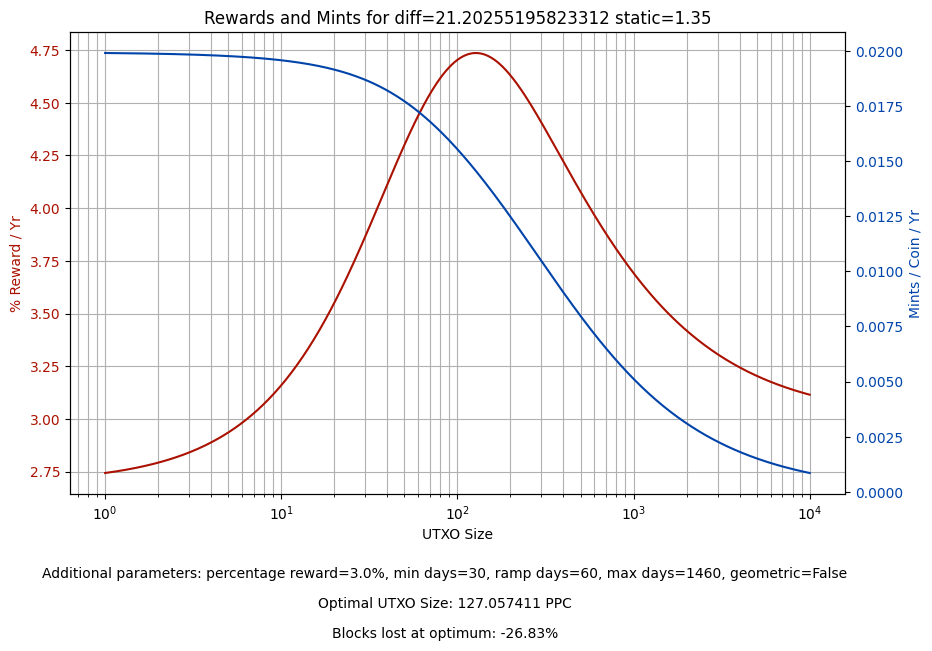

In [28]:
fig, rewardAx = plt.subplots(figsize=(10, 6))
rewardAx.set_title(f"Rewards and Mints for diff={DIFF} static={STATIC_REWARD}")
rewardAx.set_xlabel("UTXO Size")

colour = "#A10"
rewardAx.plot(sizes, rewardForSizes, color=colour)
rewardAx.tick_params(axis ='y', labelcolor=colour) 
rewardAx.set_ylabel("% Reward / Yr", color=colour)

mintsAx = rewardAx.twinx()
colour = "#04A"
mintsAx.plot(sizes, mintsForSizes, color=colour)
mintsAx.tick_params(axis ='y', labelcolor=colour) 
mintsAx.set_ylabel("Mints / Coin / Yr", color=colour)

addFigText(sizes[rewardForSizes.argmax()])

blockLoss = (1 - mintsForSizes[rewardForSizes.argmax()] / mintsForSizes.max())*100
plt.figtext(0.5, -0.13, f"Blocks lost at optimum: -{blockLoss:.2f}%", ha="center", fontsize=10)

plt.xscale("log")
rewardAx.grid(which="both")
plt.show()

## Optimal UTXO Size

In [29]:
# UTXO Size
maxI = rewardForSizes.argmax()
sizes[maxI]

127.05741052085419

In [30]:
# Reward
maxReward = rewardForSizes.max()
maxReward

4.736002499253003

In [31]:
def findWithinTolerance(it, tolerance):
    for i in it:
        if (maxReward - rewardForSizes[i] > tolerance):
            return sizes[i+1]

In [32]:
# -10bps Left
findWithinTolerance(reversed(range(0, maxI)), 0.1)

84.72274141405963

In [33]:
# -10bps Right
findWithinTolerance(range(maxI, len(sizes)), 0.1)

201.37242498623874

In [34]:
# -20bps Left
findWithinTolerance(reversed(range(0, maxI)), 0.2)

70.46930689671471

In [35]:
# -20bps Right
findWithinTolerance(range(maxI, len(sizes)), 0.2)

246.60393372343387

## Peak-finder

In [36]:
def findPeak(diff, staticReward, iterations):
    
    size = 10
    reward = averageReward(size, diff, staticReward)
    movement = 2

    for i in range(iterations):
        
        nextSize = size*movement
        nextReward = averageReward(nextSize, diff, staticReward)

        if nextReward > reward:
            size = nextSize
            reward = nextReward
        else:
            # Reverse movement and go back at slightly less than half relative pace
            movement = 1 / movement**0.45

    return (size, reward)

In [37]:
findPeak(DIFF, STATIC_REWARD, iterations=20)

(127.28753773110417, 4.736004216983745)

In [38]:
maxDiff = DIFF / securityLevel

In [39]:
# Very small difference after 20 iterations
findPeak(maxDiff, STATIC_REWARD, iterations=1000)[1] - findPeak(maxDiff, STATIC_REWARD, iterations=20)[1]

3.022560823850995e-08

In [40]:
# 15 iterations likely OK
findPeak(maxDiff, STATIC_REWARD, iterations=1000)[1] - findPeak(maxDiff, STATIC_REWARD, iterations=15)[1]

6.232855707111185e-07

In [41]:
# 15 iterations OK, even if difficulty were to be extreme
findPeak(1000, STATIC_REWARD, iterations=15)

(19226.427469852104, 3.024545085101301)

In [42]:
findPeak(1000, STATIC_REWARD, iterations=1000)[1] - findPeak(1000, STATIC_REWARD, iterations=15)[1]

0.0002497707184185849

In [43]:
# 15 iterations OK, likewise with extremely small (unreasonably small) utxo optimum.
findPeak(1, STATIC_REWARD, iterations=15)

(0.12691443693066182, 57.00318970477253)

In [44]:
findPeak(1, STATIC_REWARD, iterations=1000)[1] - findPeak(1, STATIC_REWARD, iterations=15)[1]

0.11400906531672206

## Peak across difficulties

In [45]:
optimumForDiff = np.fromiter((findPeak(x, STATIC_REWARD, iterations=30)[0] for x in range(1, 100)), dtype=float)

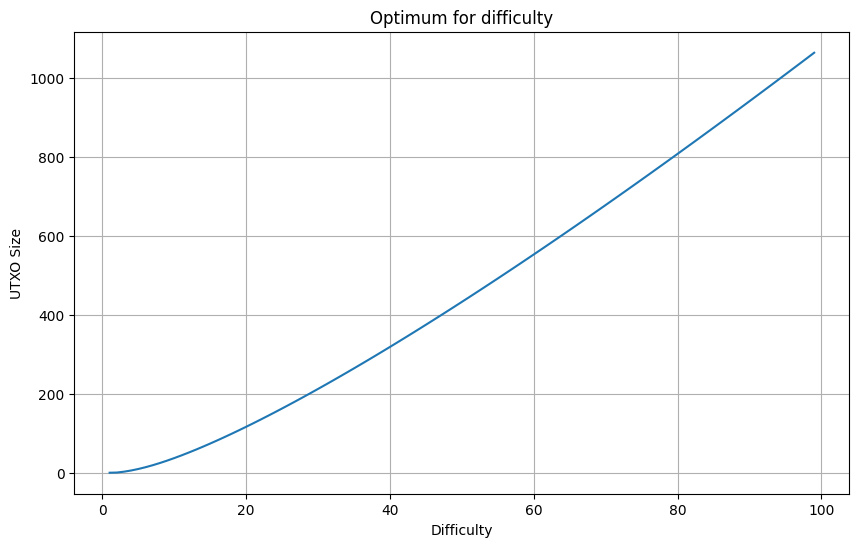

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 100), optimumForDiff)
ax.set_xlabel("Difficulty")
ax.set_ylabel("UTXO Size")
ax.set_title("Optimum for difficulty")
plt.grid(which="both")
plt.show()

## Multi-output Simulation

Since the geometric simulation looks at a single output in isolation, a wallet containing many smaller outputs may produce a different outcome.

In [47]:
import random, math

In [48]:
def randomDaysToMint(size):

    adj = size / DIFF
    daysToMint=MIN_PROB_DAYS+0.5
    dayProbs = 1 - (1 - probSecs[:RAMP_UP+1]*adj)**SECDAY

    for x in range(RAMP_UP):
        if random.random()<dayProbs[x]:
            return daysToMint
        daysToMint+=1

    days = daysToMint+np.random.geometric(dayProbs[-1])
    return days if days < NO_MINT_DAY else NO_MINT_DAY

def calcReward(size, daysToMint):
    return 0 if daysToMint == NO_MINT_DAY else size*RELATIVE_REWARD*min(365, daysToMint)/DAYYEAR + STATIC_REWARD

def multiSim(size, n, sims=50000):

    # Split if over size*2^0.5
    maxSize = size*2**0.5
    
    startBalance = size*n
    simDay = 0

    mintDayIndices = np.random.choice(MAX_DAYS+1, size=n, p=generateDailyProbs(size, DIFF))
    nextMintDays = np.take(DAYS_WITH_NO_MINT, mintDayIndices)
    nextMintRewards = np.take(dailyRewards(size, STATIC_REWARD), mintDayIndices)
    outBalances = np.full(n, size, dtype=float)

    for i in range(sims):
        
        simDay = nextMintDays.min()
        index = nextMintDays.argmin()

        newBalance = outBalances[index] + nextMintRewards[index]

        # Split?
        if newBalance > maxSize:
            newBalance /= 2

            # Add new split utxo
            daysToMint = randomDaysToMint(newBalance)
            reward = calcReward(newBalance, daysToMint)
            nextMintDays = np.append(nextMintDays, simDay + daysToMint)
            nextMintRewards = np.append(nextMintRewards, reward)
            outBalances = np.append(outBalances, newBalance)

        # Update current utxo
        daysToMint = randomDaysToMint(newBalance)
        reward = calcReward(newBalance, daysToMint)
        nextMintDays[index] = simDay + daysToMint
        nextMintRewards[index] = reward
        outBalances[index] = newBalance;            
            
    endBalance = outBalances.sum()
    return ((endBalance/startBalance)**(DAYYEAR/nextMintDays.min())-1)*100

In [49]:
def simAndPrint(size, n):
    size = math.floor(size*1000000)/1000000
    print(f"{size}*{n}")
    return multiSim(size, n)

In [50]:
simSizes = [10**(x/10) for x in range(41)]
simulatedReward = np.fromiter((simAndPrint(x, int(10000//x)) for x in simSizes), dtype=float)

1.0*10000
1.258925*7943
1.584893*6309
1.995262*5011
2.511886*3981
3.162277*3162
3.981071*2511
5.011872*1995
6.309573*1584
7.943282*1258
10.0*1000
12.589254*794
15.848931*630
19.952623*501
25.118864*398
31.622776*316
39.810717*251
50.118723*199
63.095734*158
79.432823*125
100.0*100
125.892541*79
158.489319*63
199.526231*50
251.188643*39
316.227766*31
398.10717*25
501.187233*19
630.957344*15
794.328234*12
1000.0*10
1258.925411*7
1584.893192*6
1995.262314*5
2511.886431*3
3162.27766*3
3981.071705*2
5011.872336*1
6309.573444*1
7943.282347*1
10000.0*1


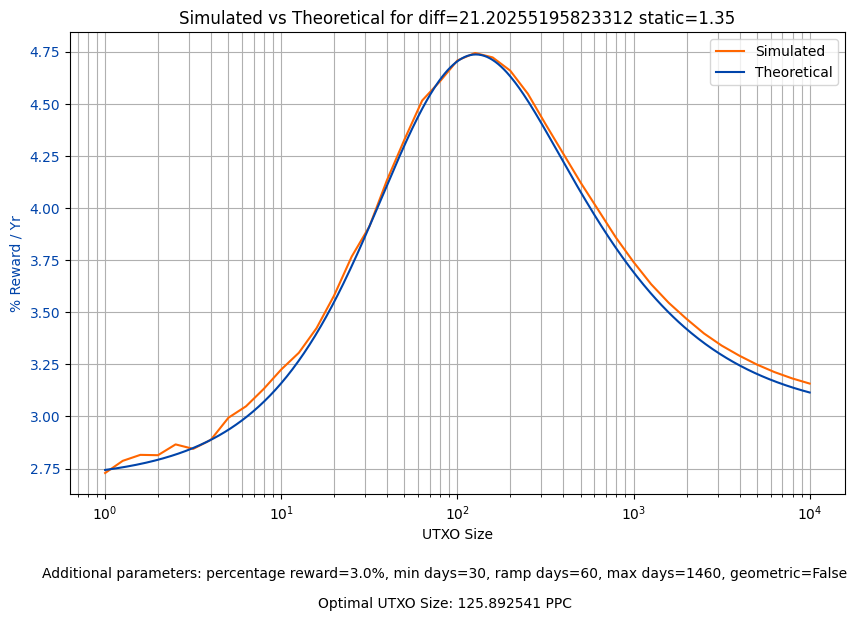

In [51]:
fig, rewardAx = plt.subplots(figsize=(10, 6))
rewardAx.set_title(f"Simulated vs Theoretical for diff={DIFF} static={STATIC_REWARD}")
rewardAx.set_xlabel("UTXO Size")
rewardAx.tick_params(axis ='y', labelcolor=colour) 
rewardAx.set_ylabel("% Reward / Yr", color=colour)

p1, = rewardAx.plot(simSizes, simulatedReward, color="#F60", label="Simulated")
p2, = rewardAx.plot(sizes, rewardForSizes, color="#04A", label="Theoretical")
rewardAx.legend(handles=[p1, p2])

addFigText(simSizes[simulatedReward.argmax()])

plt.xscale("log")
rewardAx.grid(which="both")
plt.show()